In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2")

In [114]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")
total_counts_big = total_counts_big[:, 1:-1]

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

In [115]:
C

<5527x4434 sparse matrix of type '<class 'numpy.int64'>'
	with 6208 stored elements in Compressed Sparse Row format>

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/py

<Axes: xlabel='Atoms/cell', ylabel='Count'>

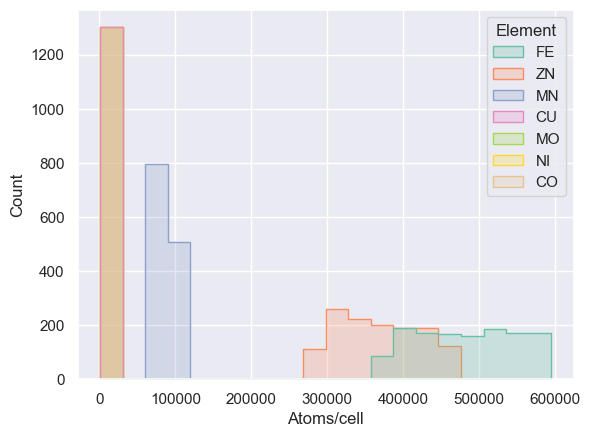

In [116]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")
sns.histplot(element_df, x="Atoms/cell", hue="Element", element="step")

# plt.xscale("log")

In [178]:
val_df = pl.read_csv('external_data/distances.csv')

val_df = val_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_df = val_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_df = val_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_df

# filter out the elements
val_df = val_df.filter(pl.col("Element").is_in(elements) & pl.col("Cell") == True)

# val_df = val_df.filter(pl.col("Condition") == "Rich")

val_df

Condition,Below LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log concentration,Concentration (M),Atoms/cell
str,i64,i64,str,f64,f64,f64,f64,f64,f64,f64
"""Minimal""",0,1,"""MO""",138.225817,354.0,9.08603,1000.0,-5.485784,0.000003,3983.324414
"""Minimal""",0,1,"""ZN""",205.106947,354.0,9.08603,55212.922173,-3.785417,0.000164,199808.236064
"""Minimal""",0,1,"""CU""",149.815832,354.0,9.08603,1000.0,-5.191123,0.000006,7850.676467
"""Minimal""",1,1,"""NI""",137.331179,354.0,9.08603,1000.0,-5.508529,0.000003,3780.077086
"""Minimal""",1,1,"""CO""",103.448109,354.0,9.08603,1000.0,-6.369963,4.2662e-7,520.075813
"""Minimal""",0,1,"""FE""",203.321486,354.0,9.08603,24669.603524,-3.83081,0.000148,179978.374255
"""Minimal""",0,1,"""MN""",131.088853,354.0,9.08603,1000.0,-5.667233,0.000002,2622.99489
"""Rich""",0,1,"""MO""",146.248788,353.14,9.30606,1000.0,-5.272756,0.000005,10797.032626
"""Rich""",0,1,"""ZN""",207.787945,353.14,9.30606,88105.726872,-3.704391,0.000198,399640.415582


hue: Minimal; y-values: [179978.37425549785 199808.2360640816 2622.994890064657 7850.6764669061995
 3983.3244143617426 3780.0770861096153 520.0758131101658]
hue: Rich; y-values: [607143.1845008492 399640.41558213835 46743.62640723306 87576.66828978057
 10797.032625735044 3240.2693333853576 443.5589077593331]


/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


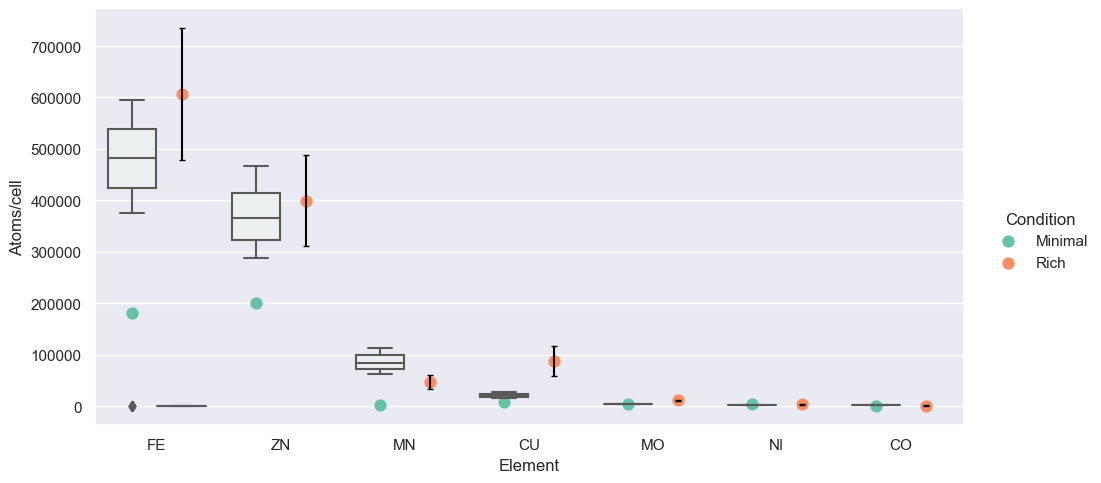

In [207]:
g = sns.catplot(data=val_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Condition",  kind="point", aspect=2, order=elements, join=False, dodge=.4)

element_df = element_df.with_columns(Condition = pl.lit("Minimal"))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": 0, "Source": "Minimal", "Condition": "Rich"})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
        print(f"hue: {path.get_label()}; y-values: {points[:, 1]}")
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[1]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[1]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Rich") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Condition")

# plt.yscale("log")

In [ ]:
conc2=[0,0,0,1,1,1,2,2,2]
width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,]
x = np.array(conc2)+np.array(add)

plt.errorbar(x = x, y = df['average'],
            yerr=df['sd'], fmt='none', c= 'black', capsize = 2)

[128046.98972099856,
 88105.72687224665,
 12922.173274596222,
 29368.57562408218,
 1000.0,
 1000.0,
 1000.0]

In [196]:
# generate the following values from the "Error" column in this order:
# 1-7. ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"] in rich 

[-0.2, 0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2]